## Performance Chasing

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [132]:
df = pd.read_csv('Kapil_Data.csv')
df['Date'] = pd.to_datetime(df['Date'])

In [133]:
def giveSharpe(fund):    
    AnnualizedReturn = np.prod(fund['Rate of Return'].div(100) +1)-1

    AnnualizedStd = np.std(fund['Rate of Return'].div(100))*np.sqrt(12)

    return AnnualizedReturn/AnnualizedStd

In [134]:
#Combined Function
#gives dataframe of top ranked funds and fund names
def rankFundsOnSharpe_2(year, prev_year_funds = False):
    #Filtering data outside these dates
    mask = (df['Date'] >= str(year) + '-01-01') & (df['Date'] <= str(year) + '-12-31')

    df_live_funds = df.loc[mask] # hedge funds that have reported from  1/1/2008 – 12/31/2017

    #df_mask

    #df_mask[df_mask['Fund Name'] == 'Fund-21']

    # Should not remove Graveyard funds

    #df_live_funds = df_mask[df_mask['Live or Graveyard Fund'] == 'Live']

    #Choosing Funds that only have return for all the months under that 10 year period

    months = np.arange(1,13)
    years = [year]
    YearAndMonth = []
    for year in years:
        for month in months:
            YearAndMonth.append([year, month])


    funds = df_live_funds['Fund Name'].unique()

    Returns_year_month = {}
    for fund in funds:
        for date in df_live_funds[df_live_funds['Fund Name'] == fund]["Date"]:
            Returns_year_month.setdefault(fund, []).append([date.year, date.month])

    removeFunds = []
    for fund, ym in Returns_year_month.items():
        if Returns_year_month[fund] != YearAndMonth:
            removeFunds.append(fund)

    #Returns_year_month

    #len(removeFunds)

    active_funds = set(funds) - set(removeFunds)

    #len(active_funds)

    #removeFunds

    #https://cmdlinetips.com/2018/02/how-to-subset-pandas-dataframe-based-on-values-of-a-column/
    # use the isin() for filtering df based on a list of values in a column
    df_active_funds = df_live_funds[df_live_funds['Fund Name'].isin(active_funds)]
    
    # Create a dictionary of DataFrames Fundwise
    df_af = df_active_funds[['Fund Name', 'Date', 'Rate of Return', 'NAV']].copy()

    #df_af.describe()

    #len(df_af)
    #len(df_af['Fund Name'].unique())

    funds = df_af['Fund Name'].unique()
    fund_separated = {}##Dictionary with Key: Fund Name and Value : dataframe

    for fund in funds:
        fund_separated[fund] = df_af[df_af['Fund Name'] == fund]
    
    fund_Sharpe = [[str(fund), giveSharpe(fund_df)] for fund, fund_df in fund_separated.items()]
    sharpe_df = pd.DataFrame(fund_Sharpe, columns = ['Fund', 'Sharpe'])

    #assigning a percentile ranking
    sharpe_df['Rank']= sharpe_df.Sharpe.rank(pct=True , ascending = False).mul(100)

    ranked_funds = sharpe_df.sort_values('Rank', ascending = True)
    if prev_year_funds:
        ranked_prevYear_Funds = ranked_funds[ranked_funds['Fund'].isin(prev_year_funds)]

        closed_prev_funds = set(prev_year_funds) - set(ranked_prevYear_Funds['Fund'].unique())

        closed_prev_funds_ranking = []
        for fund in list(closed_prev_funds):
            closed_prev_funds_ranking.append([fund, -999, 100])

        all_prevFunds_ranking = ranked_prevYear_Funds.append(pd.DataFrame(closed_prev_funds_ranking, columns = ['Fund', 'Sharpe', 'Rank']), ignore_index = True)
        overall_rank = np.mean(all_prevFunds_ranking['Rank'])
    
    else:
        overall_rank = 'not calculated'
    top10percentRankedFunds_df = ranked_funds[:int(len(ranked_funds)/10)]
    funds_to_consider_next = [fund for fund in top10percentRankedFunds_df['Fund']]
    #return top10percentRankedFunds_df , funds_to_consider_next
    return funds_to_consider_next, overall_rank

In [135]:
funds = False
year = np.arange(1995, 2006)

In [136]:
y_rank = []
for year in year:
    funds, overall_rank = rankFundsOnSharpe_2(year, funds)
    y_rank.append(overall_rank)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


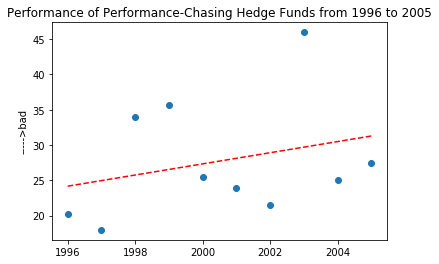

In [141]:
years = np.arange(1995, 2006)
z = np.polyfit(years[1:], y_rank[1:], 1)
p = np.poly1d(z)
plt.scatter(years[1:], y_rank[1:])

plt.plot(years[1:],p(years[1:]),"r--")
plt.ylabel('----->bad')
plt.title('Performance of Performance-Chasing Hedge Funds from 1996 to 2005')
plt.show()